In [10]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [11]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [12]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [13]:

# Initialization for system model.
A = 1
H = 1
Q = 0.1
R = 7
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

In [14]:
forecasting = 20

In [15]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_7.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,7,0.296,2.25,-20
1,2011.3.7 18:29,7,0.297,2.25,-20
2,2011.3.8 6:29,7,0.298,2.25,-20
3,2011.3.8 18:29,7,0.298,2.25,-20
4,2011.3.9 6:29,7,0.296,2.25,-20
...,...,...,...,...,...
250,2011.8.30 5:28,7,0.619,2.29,-20
251,2011.8.30 17:28,7,0.620,2.30,-20
252,2011.8.31 5:28,7,0.623,2.30,-20
253,2011.8.31 16:09,7,0.639,2.30,-20


In [16]:
df = df['Resistance']
df

0      0.296
1      0.297
2      0.298
3      0.298
4      0.296
       ...  
250    0.619
251    0.620
252    0.623
253    0.639
254    0.634
Name: Resistance, Length: 255, dtype: float64

<AxesSubplot:>

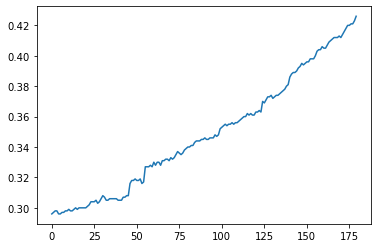

In [17]:
df = df[:180]
df.plot()

In [18]:
n_samples = len(df)
x_0 = df[1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

df = r_esti_save

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [20]:
train = df_scaled

In [21]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [22]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [23]:
x_train.shape

(128, 20, 1)

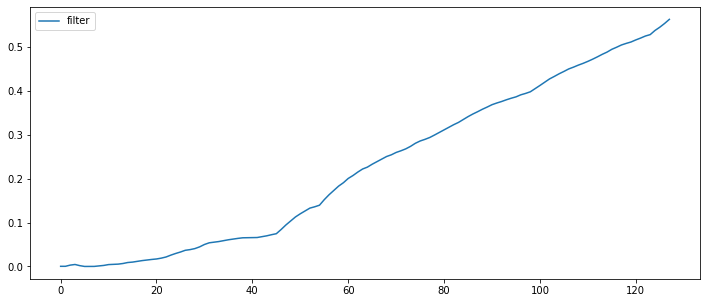

In [24]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

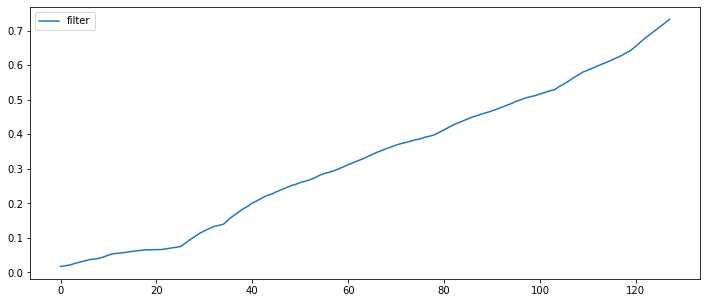

In [25]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [26]:
OUT_STEPS = 20

In [27]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(30, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [28]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=1000, 
                    batch_size=16)

Epoch 1/1000
8/8 [==============================] - 1s 4ms/step - loss: 0.1174 - mean_absolute_error: 0.2750
Epoch 2/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.1003 - mean_absolute_error: 0.2482
Epoch 3/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0922 - mean_absolute_error: 0.2403
Epoch 4/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0725 - mean_absolute_error: 0.2020
Epoch 5/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0674 - mean_absolute_error: 0.1992
Epoch 6/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0489 - mean_absolute_error: 0.1637
Epoch 7/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0316 - mean_absolute_error: 0.1342
Epoch 8/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0167 - mean_absolute_error: 0.1031
Epoch 9/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0074 - mean_absolute_error: 0.0695
Epoch 10/1000
8/8 [

8/8 [==============================] - 0s 3ms/step - loss: 4.1359e-05 - mean_absolute_error: 0.0050
Epoch 73/1000
8/8 [==============================] - 0s 3ms/step - loss: 3.9420e-05 - mean_absolute_error: 0.0049
Epoch 74/1000
8/8 [==============================] - 0s 3ms/step - loss: 4.6189e-05 - mean_absolute_error: 0.0053
Epoch 75/1000
8/8 [==============================] - 0s 3ms/step - loss: 4.3365e-05 - mean_absolute_error: 0.0051
Epoch 76/1000
8/8 [==============================] - 0s 3ms/step - loss: 3.8764e-05 - mean_absolute_error: 0.0048
Epoch 77/1000
8/8 [==============================] - 0s 3ms/step - loss: 4.1595e-05 - mean_absolute_error: 0.0050
Epoch 78/1000
8/8 [==============================] - 0s 3ms/step - loss: 3.7494e-05 - mean_absolute_error: 0.0048
Epoch 79/1000
8/8 [==============================] - 0s 4ms/step - loss: 3.9176e-05 - mean_absolute_error: 0.0049
Epoch 80/1000
8/8 [==============================] - 0s 3ms/step - loss: 3.8709e-05 - mean_absolute_er

8/8 [==============================] - 0s 4ms/step - loss: 2.7946e-05 - mean_absolute_error: 0.0041
Epoch 144/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.8095e-05 - mean_absolute_error: 0.0042
Epoch 145/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.8513e-05 - mean_absolute_error: 0.0042
Epoch 146/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.8044e-05 - mean_absolute_error: 0.0041
Epoch 147/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.7921e-05 - mean_absolute_error: 0.0041
Epoch 148/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.7568e-05 - mean_absolute_error: 0.0041
Epoch 149/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.5188e-05 - mean_absolute_error: 0.0039
Epoch 150/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.8479e-05 - mean_absolute_error: 0.0042
Epoch 151/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.8735e-05 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 2.4778e-05 - mean_absolute_error: 0.0039
Epoch 215/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.4343e-05 - mean_absolute_error: 0.0038
Epoch 216/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.3371e-05 - mean_absolute_error: 0.0038
Epoch 217/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2643e-05 - mean_absolute_error: 0.0037
Epoch 218/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.2821e-05 - mean_absolute_error: 0.0038
Epoch 219/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.4487e-05 - mean_absolute_error: 0.0039
Epoch 220/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.5746e-05 - mean_absolute_error: 0.0040
Epoch 221/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2663e-05 - mean_absolute_error: 0.0037
Epoch 222/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.3805e-05 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 2.2806e-05 - mean_absolute_error: 0.0038
Epoch 286/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0511e-05 - mean_absolute_error: 0.0036
Epoch 287/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.4097e-05 - mean_absolute_error: 0.0038
Epoch 288/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2907e-05 - mean_absolute_error: 0.0038
Epoch 289/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.4083e-05 - mean_absolute_error: 0.0038
Epoch 290/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.1631e-05 - mean_absolute_error: 0.0037
Epoch 291/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2267e-05 - mean_absolute_error: 0.0037
Epoch 292/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0163e-05 - mean_absolute_error: 0.0035
Epoch 293/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.1922e-05 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 2.0177e-05 - mean_absolute_error: 0.0035
Epoch 356/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0600e-05 - mean_absolute_error: 0.0036
Epoch 357/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0136e-05 - mean_absolute_error: 0.0035
Epoch 358/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9683e-05 - mean_absolute_error: 0.0035
Epoch 359/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0780e-05 - mean_absolute_error: 0.0036
Epoch 360/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7577e-05 - mean_absolute_error: 0.0033
Epoch 361/1000
8/8 [==============================] - ETA: 0s - loss: 2.9781e-05 - mean_absolute_error: 0.004 - 0s 3ms/step - loss: 2.3498e-05 - mean_absolute_error: 0.0039
Epoch 362/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0530e-05 - mean_absolute_error: 0.0036
Epoch 363/1000
8/8 [=================

8/8 [==============================] - 0s 3ms/step - loss: 2.0645e-05 - mean_absolute_error: 0.0036
Epoch 426/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9804e-05 - mean_absolute_error: 0.0036
Epoch 427/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9454e-05 - mean_absolute_error: 0.0035
Epoch 428/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0212e-05 - mean_absolute_error: 0.0036
Epoch 429/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8449e-05 - mean_absolute_error: 0.0034
Epoch 430/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9181e-05 - mean_absolute_error: 0.0035
Epoch 431/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.1402e-05 - mean_absolute_error: 0.0037
Epoch 432/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9158e-05 - mean_absolute_error: 0.0035
Epoch 433/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0042e-05 - mean_abs

8/8 [==============================] - 0s 4ms/step - loss: 1.9209e-05 - mean_absolute_error: 0.0035
Epoch 497/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0248e-05 - mean_absolute_error: 0.0036
Epoch 498/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9086e-05 - mean_absolute_error: 0.0035
Epoch 499/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8754e-05 - mean_absolute_error: 0.0035
Epoch 500/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8718e-05 - mean_absolute_error: 0.0034
Epoch 501/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8013e-05 - mean_absolute_error: 0.0034
Epoch 502/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9409e-05 - mean_absolute_error: 0.0035
Epoch 503/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9262e-05 - mean_absolute_error: 0.0035
Epoch 504/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9681e-05 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.8900e-05 - mean_absolute_error: 0.0035
Epoch 567/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0802e-05 - mean_absolute_error: 0.0036
Epoch 568/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7356e-05 - mean_absolute_error: 0.0033
Epoch 569/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9492e-05 - mean_absolute_error: 0.0035
Epoch 570/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8757e-05 - mean_absolute_error: 0.0034
Epoch 571/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0920e-05 - mean_absolute_error: 0.0037
Epoch 572/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.1419e-05 - mean_absolute_error: 0.0037
Epoch 573/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.8447e-05 - mean_absolute_error: 0.0043
Epoch 574/1000
8/8 [==============================] - 0s 3ms/step - loss: 3.8762e-05 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 2.5374e-05 - mean_absolute_error: 0.0041
Epoch 637/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0098e-05 - mean_absolute_error: 0.0036
Epoch 638/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7889e-05 - mean_absolute_error: 0.0034
Epoch 639/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8753e-05 - mean_absolute_error: 0.0035
Epoch 640/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7671e-05 - mean_absolute_error: 0.0034
Epoch 641/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6771e-05 - mean_absolute_error: 0.0033
Epoch 642/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7673e-05 - mean_absolute_error: 0.0034
Epoch 643/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6997e-05 - mean_absolute_error: 0.0033
Epoch 644/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0064e-05 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.4482e-05 - mean_absolute_error: 0.0031
Epoch 707/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7033e-05 - mean_absolute_error: 0.0033
Epoch 708/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7842e-05 - mean_absolute_error: 0.0033
Epoch 709/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6592e-05 - mean_absolute_error: 0.0032
Epoch 710/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7541e-05 - mean_absolute_error: 0.0033
Epoch 711/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.1867e-05 - mean_absolute_error: 0.0037
Epoch 712/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8779e-05 - mean_absolute_error: 0.0034
Epoch 713/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7190e-05 - mean_absolute_error: 0.0033
Epoch 714/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5928e-05 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.6891e-05 - mean_absolute_error: 0.0033
Epoch 777/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5815e-05 - mean_absolute_error: 0.0032
Epoch 778/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7419e-05 - mean_absolute_error: 0.0033
Epoch 779/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5457e-05 - mean_absolute_error: 0.0032
Epoch 780/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6130e-05 - mean_absolute_error: 0.0032
Epoch 781/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6061e-05 - mean_absolute_error: 0.0032
Epoch 782/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5491e-05 - mean_absolute_error: 0.0031
Epoch 783/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4598e-05 - mean_absolute_error: 0.0031
Epoch 784/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5424e-05 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.4027e-05 - mean_absolute_error: 0.0030
Epoch 848/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3804e-05 - mean_absolute_error: 0.0030
Epoch 849/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4641e-05 - mean_absolute_error: 0.0031
Epoch 850/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3719e-05 - mean_absolute_error: 0.0030
Epoch 851/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4649e-05 - mean_absolute_error: 0.0031
Epoch 852/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6655e-05 - mean_absolute_error: 0.0033
Epoch 853/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.5893e-05 - mean_absolute_error: 0.0032
Epoch 854/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7184e-05 - mean_absolute_error: 0.0034
Epoch 855/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7354e-05 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.4044e-05 - mean_absolute_error: 0.0030
Epoch 918/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3289e-05 - mean_absolute_error: 0.0029
Epoch 919/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4589e-05 - mean_absolute_error: 0.0031
Epoch 920/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.2643e-05 - mean_absolute_error: 0.0029
Epoch 921/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4722e-05 - mean_absolute_error: 0.0031
Epoch 922/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3886e-05 - mean_absolute_error: 0.0030
Epoch 923/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4833e-05 - mean_absolute_error: 0.0031
Epoch 924/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3036e-05 - mean_absolute_error: 0.0029
Epoch 925/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3662e-05 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 2.1434e-05 - mean_absolute_error: 0.0037
Epoch 989/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5884e-05 - mean_absolute_error: 0.0032
Epoch 990/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.4988e-05 - mean_absolute_error: 0.0032
Epoch 991/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.2452e-05 - mean_absolute_error: 0.0028
Epoch 992/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3269e-05 - mean_absolute_error: 0.0029
Epoch 993/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4047e-05 - mean_absolute_error: 0.0030
Epoch 994/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6188e-05 - mean_absolute_error: 0.0032
Epoch 995/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5196e-05 - mean_absolute_error: 0.0031
Epoch 996/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6337e-05 - mean_abs

num 0 16.91085146023685 actual 0.6190476190476186 prediction 0.72373384
num 1 13.783168792724709 actual 0.6666666666666661 prediction 0.75855446
num 2 4.893063306808584 actual 0.7142857142857135 prediction 0.74923617
num 3 2.778527885675316 actual 0.7619047619047628 prediction 0.7830745
num 4 11.607627868652463 actual 0.7142857142857135 prediction 0.79719734
num 5 18.96572411060344 actual 0.6666666666666661 prediction 0.7931048
num 6 22.895625233650314 actual 0.6666666666666661 prediction 0.81930417
num 7 26.070913672447315 actual 0.6666666666666661 prediction 0.84047276
num 8 15.566254854202393 actual 0.7142857142857135 prediction 0.82547325
num 9 17.40015029907239 actual 0.7142857142857135 prediction 0.8385725
num 10 19.404785633087286 actual 0.7142857142857135 prediction 0.8528913
num 11 27.414387464523426 actual 0.6666666666666661 prediction 0.84942925
num 12 24.000025987625254 actual 0.7142857142857135 prediction 0.8857145
num 13 16.29350520670401 actual 0.7619047619047628 predict

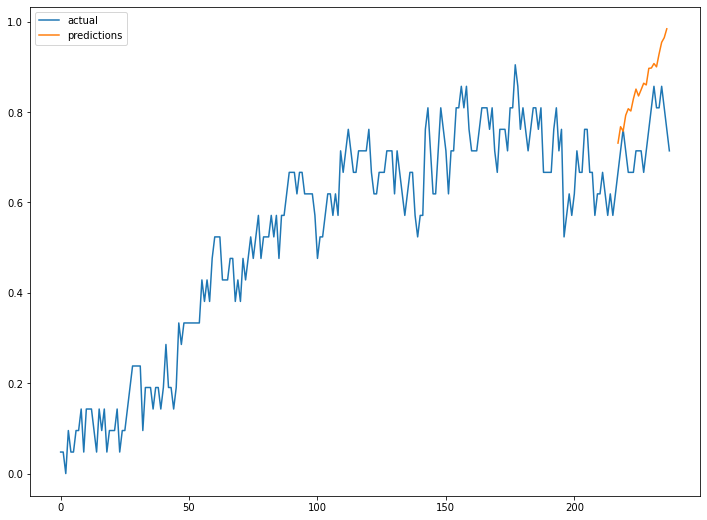

In [29]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 8.636230935855767 actual 0.8006535947712417 prediction 0.7315073
num 1 4.78972004305932 actual 0.8104575163398693 prediction 0.7716389
num 2 7.941960713949547 actual 0.8137254901960784 prediction 0.74909973
num 3 2.0125068664550763 actual 0.8169934640522876 prediction 0.8005514
num 4 0.36492500305175585 actual 0.8169934640522876 prediction 0.81401205
num 5 2.2687113142583444 actual 0.8202614379084967 prediction 0.8016521
num 6 1.4245012532109862 actual 0.826797385620915 prediction 0.8385751
num 7 2.512212609872232 actual 0.8366013071895424 prediction 0.8576185
num 8 1.0778863457639105 actual 0.8464052287581698 prediction 0.83728194
num 9 0.18645483871987814 actual 0.8529411764705881 prediction 0.8545315
num 10 0.8472035139685996 actual 0.8594771241830064 prediction 0.86675864
num 11 0.1886002042076598 actual 0.8627450980392155 prediction 0.86111796
num 12 5.142733870812205 actual 0.8660130718954246 prediction 0.9105498
num 13 4.411349116631297 actual 0.8660130718954246 prediction

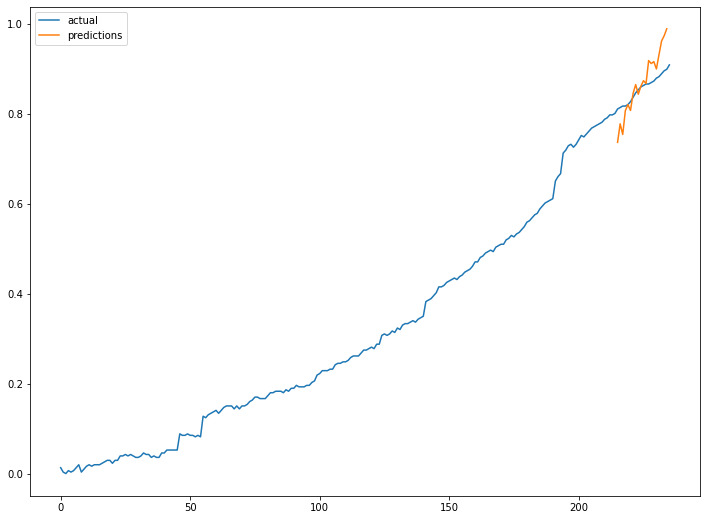

In [30]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 3.745473950065692 actual 0.6762402088772845 prediction 0.6509118
num 1 2.5863375627633145 actual 0.6892950391644908 prediction 0.67146754
num 2 3.478305795219482 actual 0.6971279373368144 prediction 0.6728797
num 3 1.161062097017628 actual 0.702349869451697 prediction 0.69419515
num 4 0.3781116096735699 actual 0.7075718015665795 prediction 0.7048964
num 5 1.1613679193232211 actual 0.7154046997389034 prediction 0.7070962
num 6 0.8073206870786572 actual 0.7284595300261096 prediction 0.7225785
num 7 0.37003955655721765 actual 0.7389033942558747 prediction 0.73616916
num 8 2.0315670593274824 actual 0.7493472584856395 prediction 0.73412377
num 9 1.5253621814160048 actual 0.7545691906005221 prediction 0.7430593
num 10 1.3520538603486378 actual 0.7650130548302871 prediction 0.75466967
num 11 1.4212421413992615 actual 0.7676240208877285 prediction 0.7567142
num 12 1.295451931401978 actual 0.7676240208877285 prediction 0.7775682
num 13 0.29530091173698253 actual 0.7780678851174934 predict

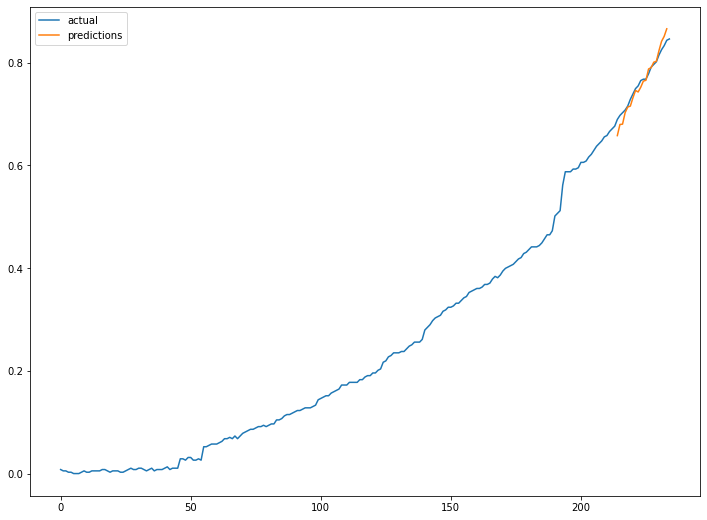

In [31]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 2.1888080396149556 actual 0.7916666666666661 prediction 0.7743386
num 1 3.990542261224122 actual 0.7916666666666661 prediction 0.82325846
num 2 0.8513827072947403 actual 0.7916666666666661 prediction 0.7984068
num 3 13.643844922383627 actual 0.75 prediction 0.85232884
num 4 9.747101131238518 actual 0.7916666666666661 prediction 0.8688312
num 5 13.840850194295248 actual 0.75 prediction 0.8538064
num 6 7.265243530273362 actual 0.8333333333333339 prediction 0.893877
num 7 10.124442577361982 actual 0.8333333333333339 prediction 0.9177037
num 8 2.5576483119617177 actual 0.9166666666666661 prediction 0.89322156
num 9 4.7951884891676455 actual 0.9583333333333339 prediction 0.91237944
num 10 3.315330588299355 actual 0.9583333333333339 prediction 0.9265614
num 11 4.147919364597546 actual 0.9583333333333339 prediction 0.91858244
num 12 1.279105310854642 actual 0.9583333333333339 prediction 0.9705914
num 13 0.933767401653725 actual 0.9583333333333339 prediction 0.96728194
num 14 6.230809471

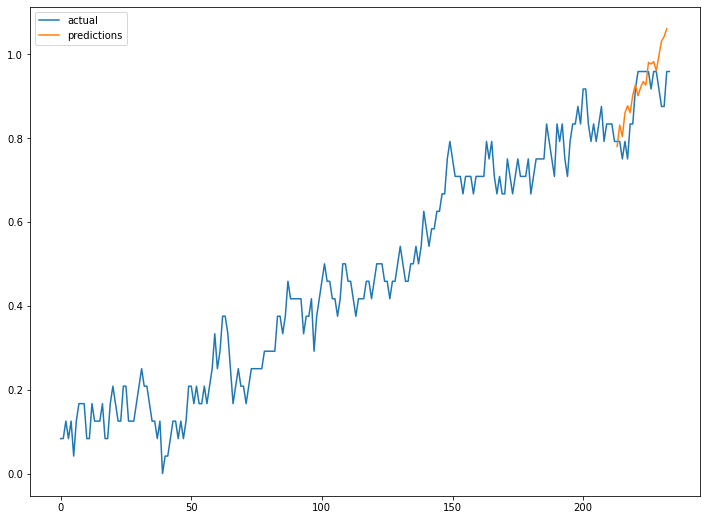

In [32]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 8.430797175357203 actual 0.8482142857142856 prediction 0.77670306
num 1 3.0126680930455096 actual 0.8571428571428568 prediction 0.83132
num 2 6.779195885909218 actual 0.8482142857142856 prediction 0.7907122
num 3 1.243644235021811 actual 0.8526785714285712 prediction 0.86328286
num 4 1.402854919433616 actual 0.8660714285714284 prediction 0.87822115
num 5 2.2903510502406528 actual 0.875 prediction 0.8549594
num 6 3.1774714513478695 actual 0.8794642857142856 prediction 0.907409
num 7 4.733542820916148 actual 0.8883928571428568 prediction 0.9304453
num 8 1.3783637923423981 actual 0.8839285714285712 prediction 0.8961123
num 9 3.496240012010782 actual 0.8883928571428568 prediction 0.9194532
num 10 5.439858484749872 actual 0.8839285714285712 prediction 0.93201303
num 11 3.0391941070556716 actual 0.8928571428571428 prediction 0.9199928
num 12 9.85473311773625 actual 0.901785714285714 prediction 0.9906543
num 13 7.964818230990706 actual 0.90625 prediction 0.97843117
num 14 7.905341838968

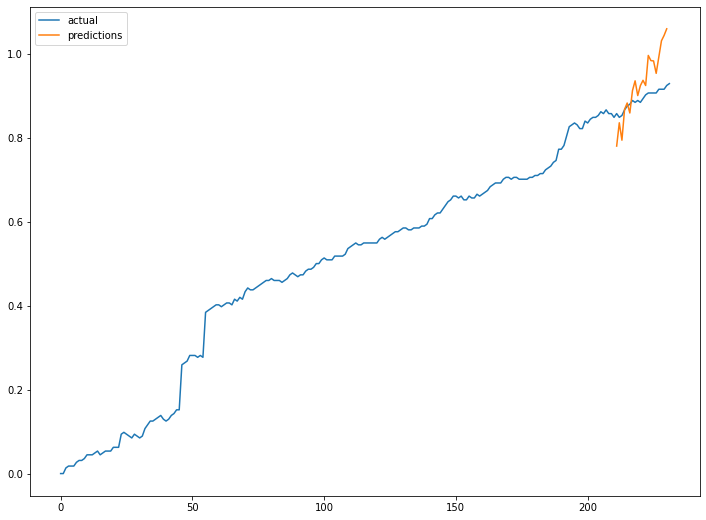

In [33]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 11.009122343624487 actual 0.8500000000000014 prediction 0.75642246
num 1 0.9523347020148334 actual 0.8000000000000007 prediction 0.8076187
num 2 2.056002616882324 actual 0.75 prediction 0.76542
num 3 12.12608814239502 actual 0.75 prediction 0.84094566
num 4 13.854877154032389 actual 0.75 prediction 0.8539116
num 5 10.671591758728027 actual 0.75 prediction 0.83003694
num 6 26.18981088910765 actual 0.7000000000000011 prediction 0.8833287
num 7 29.071218626839578 actual 0.7000000000000011 prediction 0.90349853
num 8 33.82348647484405 actual 0.6500000000000004 prediction 0.86985266
num 9 27.642512321471973 actual 0.7000000000000011 prediction 0.8934976
num 10 20.61251004536947 actual 0.75 prediction 0.9045938
num 11 19.075536727905273 actual 0.75 prediction 0.8930665
num 12 37.945694582802695 actual 0.7000000000000011 prediction 0.96561986
num 13 35.76084375381449 actual 0.7000000000000011 prediction 0.9503259
num 14 18.465870618820084 actual 0.8000000000000007 prediction 0.94772696


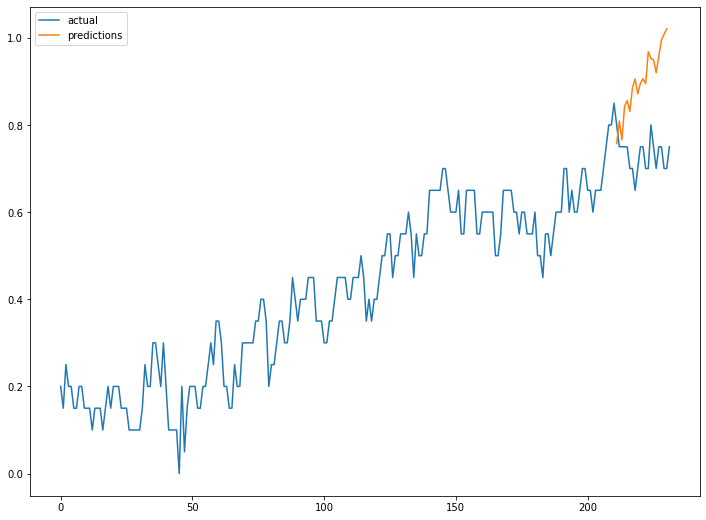

In [34]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 10.317306965589424 actual 0.8421052631578938 prediction 0.7552227
num 1 7.497035012100663 actual 0.8684210526315788 prediction 0.8033152
num 2 8.620747551321882 actual 0.8421052631578938 prediction 0.7695095
num 3 4.004111795714387 actual 0.8684210526315788 prediction 0.8336485
num 4 2.391784841364059 actual 0.8684210526315788 prediction 0.8476503
num 5 1.5371609479187827 actual 0.8421052631578938 prediction 0.82916075
num 6 7.310655809217987 actual 0.8157894736842097 prediction 0.87542903
num 7 9.967721662213833 actual 0.8157894736842097 prediction 0.8971051
num 8 2.991135790944214 actual 0.8421052631578938 prediction 0.8672938
num 9 5.439950525760768 actual 0.8421052631578938 prediction 0.8879154
num 10 3.6812417434923796 actual 0.8684210526315788 prediction 0.90038973
num 11 5.776894092559932 actual 0.8421052631578938 prediction 0.8907528
num 12 6.6514814601225405 actual 0.8947368421052628 prediction 0.9542501
num 13 8.619933778589445 actual 0.8684210526315788 prediction 0.943

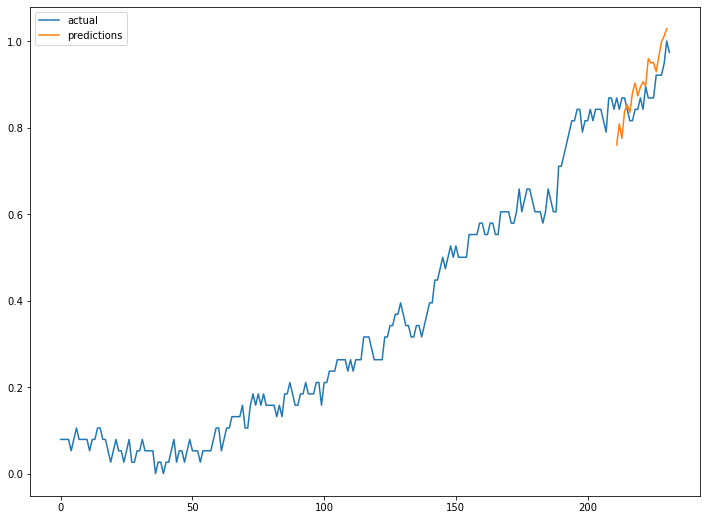

In [35]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 5.504838824272257 actual 0.76923076923077 prediction 0.72688586
num 1 4.789858742763984 actual 0.7307692307692317 prediction 0.76577204
num 2 1.8745892926264984 actual 0.7307692307692317 prediction 0.74446815
num 3 8.617978974392397 actual 0.7307692307692317 prediction 0.79374677
num 4 16.572587357627135 actual 0.6923076923076916 prediction 0.807041
num 5 3.4770482778548093 actual 0.76923076923077 prediction 0.7959773
num 6 2.954355875650955 actual 0.8076923076923084 prediction 0.8315544
num 7 5.349626427604949 actual 0.8076923076923084 prediction 0.8509008
num 8 1.8358122218739539 actual 0.8461538461538467 prediction 0.83062005
num 9 4.8710209982734884 actual 0.8076923076923084 prediction 0.84703517
num 10 11.737338900565982 actual 0.76923076923077 prediction 0.859518
num 11 11.035377383231998 actual 0.76923076923077 prediction 0.8541183
num 12 17.35523164272296 actual 0.76923076923077 prediction 0.90273255
num 13 10.988506816682268 actual 0.8076923076923084 prediction 0.8964456

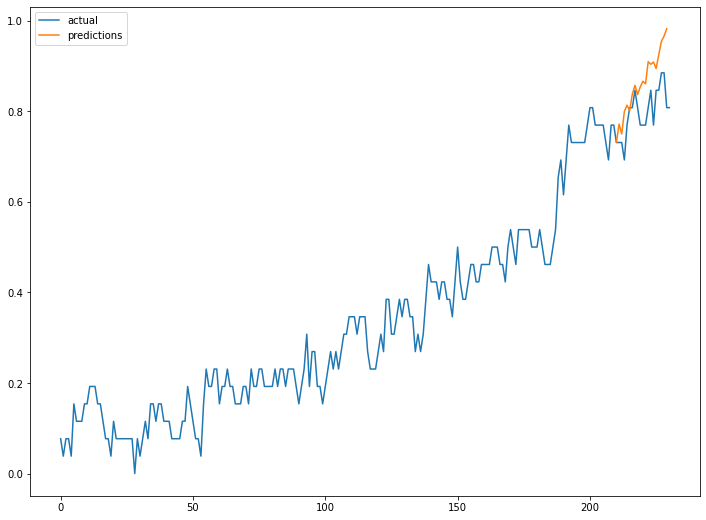

In [36]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 5.7008151213327745 actual 0.7389162561576352 prediction 0.696792
num 1 2.758609268226118 actual 0.7487684729064039 prediction 0.7281129
num 2 5.113555286444823 actual 0.7536945812807878 prediction 0.715154
num 3 0.4897109486839647 actual 0.7586206896551722 prediction 0.75490564
num 4 0.18980262371209297 actual 0.7684729064039408 prediction 0.7670143
num 5 1.655432297165993 actual 0.7733990147783252 prediction 0.7605959
num 6 1.3440462607372026 actual 0.7783251231527091 prediction 0.7887862
num 7 2.7901619485339513 actual 0.7832512315270934 prediction 0.8051052
num 8 0.5467232689261531 actual 0.7881773399014778 prediction 0.7924865
num 9 1.6632422156955844 actual 0.7931034482758621 prediction 0.8062947
num 10 2.5069155074932357 actual 0.798029556650246 prediction 0.8180355
num 11 2.228770800578781 actual 0.798029556650246 prediction 0.8158158
num 12 5.693179768760043 actual 0.8078817733990147 prediction 0.85387594
num 13 3.37574735373083 actual 0.8226600985221673 prediction 0.8504

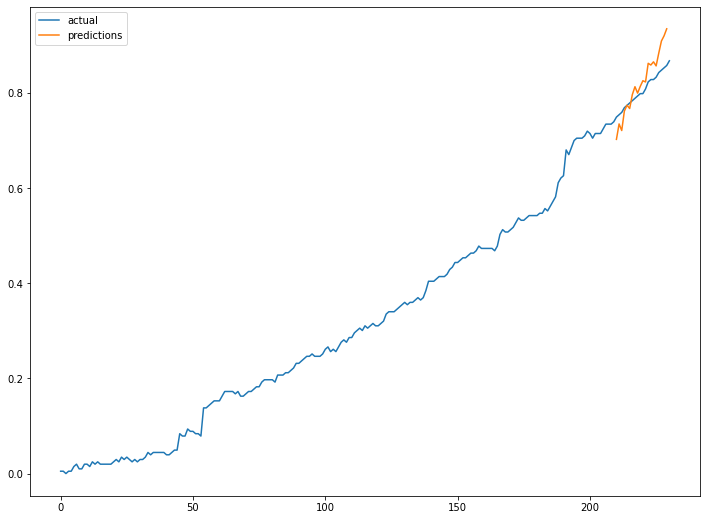

In [37]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()